In [23]:
import matplotlib.pyplot as plt
import numpy as np

import astropy
import astropy.coordinates
from astropy.time import Time

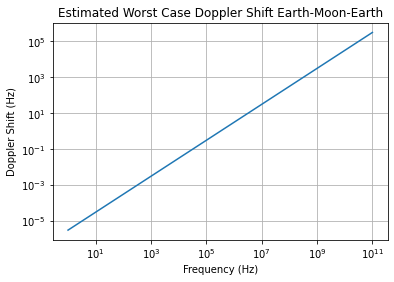

In [24]:
c = 299792458 #m/s
doppler = lambda f, v: f/((1-v**2/c**2)**(1/2)*(1 + v/c))


plt.xscale('log')
plt.yscale('log')
freq = np.geomspace(1, 10e10)
moon_recieve = doppler(freq, 460)
earth_recieve = doppler(moon_recieve, 460)
shift = (freq- earth_recieve)

plt.grid()
plt.title('Estimated Worst Case Doppler Shift Earth-Moon-Earth')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Doppler Shift (Hz)')
plt.plot(freq, shift)
plt.savefig('worst_case_estimate')


In [25]:
from astropy.utils import iers
from astropy.coordinates import get_body_barycentric,get_body_barycentric_posvel, get_body, get_moon
from astropy.coordinates import solar_system_ephemeris
from astropy.coordinates import EarthLocation
from astropy import units
from astropy.coordinates import CartesianRepresentation, CartesianDifferential, SkyCoord, GCRS
from math import acos, cos
from astropy.timeseries import TimeSeries


iers.conf.iers_auto_url = 'ftp://cddis.gsfc.nasa.gov/pub/products/iers/finals2000A.all'
solar_system_ephemeris.set('jpl') 


c = 299792458 #m/s
doppler = lambda f, v, costheta: f/((1-v**2/c**2)**(1/2) *  (1 + v/c * costheta))


def get_doppler(frequency, emitter, reciever, time):
    #ICRS
    moon_loc, moon_vel = get_body_barycentric_posvel('moon', time)
    moon_loc = SkyCoord(
        representation_type = 'cartesian', differential_type=CartesianDifferential,unit='m',frame='icrs', 
        obstime =time, x = moon_loc.x, y= moon_loc.y, z = moon_loc.z, v_x = moon_vel.x, v_y = moon_vel.y, v_z = moon_vel.z)
    moon_coord = moon_loc.transform_to(GCRS(obstime=time))

    #GCRS
    emitter_loc, emitter_vel = emitter.get_gcrs_posvel(time)
    emitter_coord = SkyCoord(
        representation_type = 'cartesian', differential_type=CartesianDifferential,unit='m',frame='gcrs', 
        obstime =time, x = emitter_loc.x, y= emitter_loc.y, z = emitter_loc.z, 
        v_x = emitter_vel.x, v_y = emitter_vel.y, v_z = emitter_vel.z)

    #GCRS
    reciever_loc, reciever_vel = reciever.get_gcrs_posvel(time)
    reciever_coord = SkyCoord(
        representation_type = 'cartesian', differential_type=CartesianDifferential,unit='m',frame='gcrs', 
        obstime =time, x = reciever_loc.x, y= reciever_loc.y, z = reciever_loc.z, 
        v_x = reciever_vel.x, v_y = reciever_vel.y, v_z = reciever_vel.z)


    #Let the moon be reciever, earth source
    #Sign error on angle (?)
    delta_pos_e_m = CartesianRepresentation(x=(emitter_coord.cartesian.xyz-moon_coord.cartesian.xyz), unit='m')
    delta_v_e_m = CartesianDifferential(d_x = (emitter_coord.velocity-moon_coord.velocity).get_d_xyz(), unit='m/s').to_cartesian()
    theta_e_m = delta_pos_e_m.dot(delta_v_e_m)/(delta_pos_e_m.norm() * delta_v_e_m.norm())
    delta_v_e_m_norm= delta_v_e_m.norm().value
    #delta_v_e_m_norm *= -1 if delta_v_e_m.dot(delta_pos_e_m) > 0 else 1 #If objects moving towards eachother -v

    #print(delta_v_e_m_norm)
    shifted_e_m = doppler(frequency, delta_v_e_m_norm, theta_e_m)


    delta_pos_m_e = CartesianRepresentation(x=(moon_coord.cartesian.xyz-reciever_coord.cartesian.xyz), unit='m')
    delta_v_m_e = CartesianDifferential(d_x = (moon_coord.velocity-reciever_coord.velocity).get_d_xyz(), unit='m/s').to_cartesian()
    theta_m_e = delta_pos_m_e.dot(delta_v_m_e)/(delta_pos_m_e.norm() * delta_v_m_e.norm())
    delta_v_m_e_norm= delta_v_e_m.norm().value
    
    #delta_v_m_e_norm *= -1 if delta_v_m_e.dot(delta_pos_m_e) > 0 else 1 #If objects moving towards eachother -v
    #print(delta_v_m_e_norm)
   
    shifted_m_e = doppler(shifted_e_m, delta_v_m_e_norm, theta_m_e)

    return (shifted_e_m, shifted_m_e)


def get_normalized_dopplers(emitter, reciever, time):
    return get_dopplers(1, emitter, reciever, time)

def get_dopplers(frequency, emitter, reciever, times):
    y = np.empty(shape=(2,len(times)))
    for i, time in enumerate(times['time']):
        y1, y2 = get_doppler(frequency, emitter, reciever, time)
        y[0,i] = y1
        y[1,i] = y2
    return y

def normalize_dopplers(f):
    return (f-np.mean(f))/f

#Example continued
observed_freqs = signal #Add noise later
observed_mean_freq = np.mean(observed_freqs)
observed_doppler = observed_freqs - mean_freq
normalized_observed_doppler = observed_doppler/observed_mean_freq
plt.plot(normalized_observed_doppler[1])




NameError: name 'signal' is not defined

ValueError: Format 'jpg' is not supported (supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz)

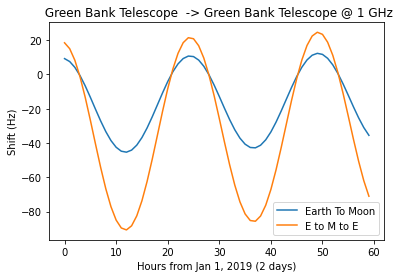

In [26]:
#Sanity Checks

emitter = EarthLocation.from_geodetic("38°25'53.6", "79°49'08.9", 0) #GBT
reciever = EarthLocation.from_geodetic("38°25'53.6", "79°49'08.9", 0) #GBT
frequency = 107.4e6
n = 60

start_time = Time('2019-01-01T00:00:00.00Z', format='isot', scale='utc')
times = TimeSeries(time_start=start_time, time_delta =units.Quantity('1h'), n_samples=n)

    
y = get_dopplers(frequency, emitter, reciever, times)
    
x = range(0, n)
plt.plot(x, y[0]-frequency, label='Earth To Moon')
plt.plot(x, y[1]-frequency, label='E to M to E')
#plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y[1]-frequency, 1))(np.unique(x)))
plt.title(' Green Bank Telescope  -> Green Bank Telescope @ 1 GHz')
plt.xlabel('Hours from Jan 1, 2019 (%i days)'%(n/24))
plt.ylabel('Shift (Hz)')
plt.legend()
plt.savefig('graph.jpg')
    



In [11]:
n = 24*3

start_time = Time('2019-01-01T00:00:00.00Z', format='isot', scale='utc')
times = TimeSeries(time_start=start_time, time_delta =units.Quantity('1h'), n_samples=n)

emitter = EarthLocation.from_geodetic(lat = "30°03'10.8",lon ="31°13'50.1", height =0) #ERTU  Broadcasting
reciever = EarthLocation.from_geodetic(lat = "38°25'53.6",lon = "79°49'08.9", 0) #GBT
frequency = 1e9

y = np.empty(shape=(2,len(times)))
for i, time in enumerate(times['time']):
    if i%24 == 0:
        print(i/24)
    y1, y2 = get_doppler(frequency, emitter, reciever, time)
    y[0,i] =y1
    y[1,i] = y2
    
x = range(0, n)
plt.plot(x, y[0]-frequency, label='Earth To Moon')
plt.plot(x, y[1]-frequency, label='E to M to E')
#plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y[1]-frequency, 1))(np.unique(x)))
plt.title(' ERTU  -> Green Bank Telescope @ 1 GHz')
plt.xlabel('Hours from Jan 1, 2019 (%i days)'%(n/24))
plt.ylabel('Shift (Hz)')
plt.legend()
plt.savefig('graph.jpg')
    

SyntaxError: positional argument follows keyword argument (<ipython-input-11-ff5b3c55cc4e>, line 6)

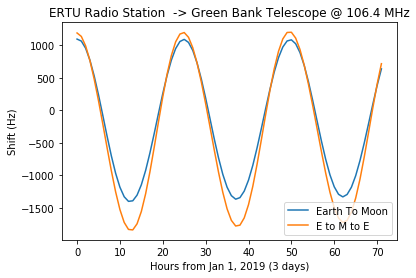

In [164]:
x = range(0, n)
plt.plot(x, y[0]-frequency, label='Earth To Moon')
plt.plot(x, y[1]-frequency, label='E to M to E')
#plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y[1]-frequency, 1))(np.unique(x)))
plt.title('ERTU Radio Station  -> Green Bank Telescope @ 106.4 MHz')
plt.xlabel('Hours from Jan 1, 2019 (%i days)'%(n/24))
plt.ylabel('Shift (Hz)')
plt.legend()              
plt.savefig('graph.jpg')

In [165]:
n = 5 * 60 * 12
timestep = '12s'
start_time = Time('2019-01-01T00:00:00.00Z', format='isot', scale='utc')


times = TimeSeries(time_start=start_time, time_delta =units.Quantity(timestep), n_samples=n)
emitter = EarthLocation.from_geodetic("30°03'10.8","31°13'50.1", 0) #ERTU  Broadcasting
reciever = EarthLocation.from_geodetic("38°25'53.6", "79°49'08.9", 0) #GBT
frequency = 107.4e6

y = np.empty(shape=(2,len(times)))
for i, time in enumerate(times['time']):
    if i%120 == 0:
        print(i/60)
    y[:, i] = get_doppler(frequency, emitter, reciever, time)


0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0


10.0
1.6666666666666667


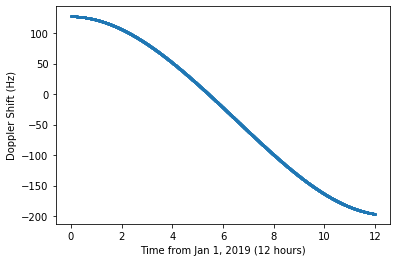

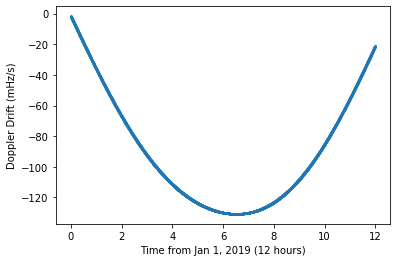

In [166]:
x= np.array(range(0,n))/5/60

accel = np.diff(y)[1]

indexes = [i for i, a in enumerate(accel) if abs(a) < .5]
xs = np.array([x[i] for i in indexes])
print(x[10 * 60 * 5])
accels = np.array([accel[i] for i in indexes])

print(x[500])

plt.scatter(x, y[1] - frequency, s=2)  # Creates the plot.  No need to save the current figure.
plt.xlabel('Time from Jan 1, 2019 (%i hours)'%(n/5/60))
plt.ylabel('Doppler Shift (Hz)')
plt.draw()  # Draws, but does not block

plt.savefig('g1.jpg')
plt.figure()  # New window, if needed.  No need to save it, as pyplot uses the concept of current figure
plt.scatter(xs, accels*1000, s=2)
plt.xlabel('Time from Jan 1, 2019 (%i hours)'%(n/5/60))
plt.ylabel('Doppler Drift (mHz/s)')
plt.draw()
plt.savefig('g2.jpg')

In [4]:
from astropy.coordinates import Longitude, Latitude
import matplotlib as mpl
import os
import prog
from importlib import reload  
import timeit
reload(prog)
from prog import DopplerSystemEME
samples = 2 * 24 #hours
timestep = units.Quantity('30min')
start_time = Time('2019-01-01T00:00:00.00Z', format='isot', scale='utc')


reciever = EarthLocation.from_geodetic(lat = "38°25'53.6", lon="79°49'08.9", height=0) #GBT
times = TimeSeries(time_start=start_time, time_delta =timestep, n_samples=samples)

emitters = []
n = 90
for i in range(0, n):
    for j in range(0,n+1):
        earth_loc = EarthLocation.from_geodetic(Longitude(i * 360 / n, units.degree), Latitude(j * 180 /n -90, units.degree))
        emitters.append(earth_loc)
print("Generating prediction for %i emitters."%len(emitters))
doppler_system = DopplerSystemEME(emitters, reciever, only_visible = True)
dopplers = doppler_system.get_dopplers(times['time'])
print(dopplers[i])
#Generating graphs
print("Generating Graphs")
def get_label(start_time, timestep):
    return str(timestep.unit) + ' since ' + str(start_time)
def get_x(n, timestep):
    return np.array([i * timestep.value for i in range(0,int(samples))])

path = '4m_4h_1M_18/'
os.makedirs(path, exist_ok=True)

Generating prediction for 8190 emitters.
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Generating Graphs


NameError: name 'backend_' is not defined

In [5]:
backend_ =  mpl.get_backend() 
mpl.use("Agg")  # Prevent showing stuff
x = get_x(samples, timestep)
for i in range(0, len(emitters)):
    emitter = emitters[i]
    lon = emitter.lon
    lat = emitter.lat
    fig = plt.figure()
    ax = fig.gca()
    ax.set_title(str(lon)+','+ str(lat))
    ax.set_ylabel('Frequency Shift, Hz')
    ax.set_xlabel(get_label(start_time, timestep))
    ax.scatter(x,dopplers[i])
    fig.savefig(path + str(lon)+'_'+ str(lat))
    plt.close(fig)
        
mpl.use(backend_)

print("Done")

Done


In [7]:
test_emitter = [EarthLocation.from_geodetic(lon="50°49'08.9", lat = "42°25'53.6", height=0)] #GBT
doppler_system_test = DopplerSystemEME(test_emitter, reciever, only_visible = True)
test_doppler = doppler_system_test.get_dopplers(times['time'])[0]



def get_closest(a, b):
    m = 99999999
    ind = -1
    c = b-a 
    for i in range(0, len(emitters)):
        if not np.isnan(c[i]).all():
            count = np.count_nonzero(~np.isnan(c))
            err  = np.nansum(np.abs(c[i]))/count
            if err < m:
                ind = i
                m = err
    return ind
    
idx = get_closest(test_doppler, dopplers)
print(emitters[idx].geodetic)
mpl.use(backend_)
ax = fig.gca()
ax.set_ylabel('Frequency Shift, Hz')
ax.set_xlabel(get_label(start_time, timestep))
ax.scatter(x,dopplers[idx], label='Trial Solution', s=4)
ax.scatter(x,test_doppler, label='Simulated', s=4)
ax.legend()
os.makedirs('output', exist_ok=True)
fig.savefig('output/demo.png')
plt.close(fig)



GeodeticLocation(lon=<Longitude 52. deg>, lat=<Latitude -44. deg>, height=<Quantity 0. m>)


In [32]:
from astropy.coordinates import Longitude, Latitude
import matplotlib as mpl
import os


def wrap_num(x, min_, max_):
    d = max_ - min_
    return  ((x - min_) % d + d) % d + min_

#Let predicted freqs be dict of loc and data
def generate_nearby(earth_location, radius, points_per_row):
    nearby = []
    
    x = earth_location.lon.value - 1/2 * radius
    y = earth_location.lat.value - 1/2 * radius/2
    for i in range(0, points_per_row):
        lon = x + (i+1/2) * radius/points_per_row
        lon = wrap_num(lon, 0, 360)
        for j in range(0, points_per_row):
            ry = radius/2
            lat = y + (i+1/2) * ry/points_per_row
            lat = wrap_num(lat, -90, 90)
            n = EarthLocation.from_geodetic(Longitude(lon, units.degree), Latitude(lat, units.degree))
            nearby.append(n)
    return nearby

def get_closest(obs_freq, predicted_freqs):
    key_min = min(predicted_freqs.keys(), key=(lambda k: ((predicted_freqs[k]-obs_freq)**2).mean()))
    return EarthLocation.from_geodetic(key_min.lon, key_min.lat), predicted_freqs[key_min], (predicted_freqs[key_min]-obs_freq)**2

#Predictor takes in earth location returns frequencies
def get_loc(obs_freq,  predictor, iters, n, silent=False):   
    loc = EarthLocation.from_geodetic(Longitude(0, units.degree), Latitude(0, units.degree))
    radius = 180
    for i in range(0, iters):
        print("Beginning Iter %i"%i)
        near = generate_nearby(loc, radius, n)+[loc]
        loc, freq, _ = get_closest(obs_freq, {l.geodetic: predictor(l) for l in near})
        radius = radius / n
    return loc, freq
        

    
emitter = EarthLocation.from_geodetic("0°", "0°", 0) #GBT
nearby  =generate_nearby(emitter, 5, 2)
print(emitter.geodetic)
[print(x.geodetic) for x in nearby]

GeodeticLocation(lon=<Longitude 0. deg>, lat=<Latitude 0. deg>, height=<Quantity 0. m>)
GeodeticLocation(lon=<Longitude -1.25 deg>, lat=<Latitude -0.625 deg>, height=<Quantity -9.66426927e-10 m>)
GeodeticLocation(lon=<Longitude -1.25 deg>, lat=<Latitude -0.625 deg>, height=<Quantity -9.66426927e-10 m>)
GeodeticLocation(lon=<Longitude 1.25 deg>, lat=<Latitude 0.625 deg>, height=<Quantity -9.66426927e-10 m>)
GeodeticLocation(lon=<Longitude 1.25 deg>, lat=<Latitude 0.625 deg>, height=<Quantity -9.66426927e-10 m>)


[None, None, None, None]

In [84]:
#Example of iterative finding
emitter = EarthLocation.from_geodetic("38°25'53.6", "79°49'08.9", 0) #GBT
reciever = EarthLocation.from_geodetic("38°25'53.6", "79°49'08.9", 0) #GBT
frequency = 107.4e6
n = 60*4

start_time = Time('2019-01-01T00:00:00.00Z', format='isot', scale='utc')
times = TimeSeries(time_start=start_time, time_delta =units.Quantity('1min'), n_samples=n)
signal = get_dopplers(frequency, emitter, reciever, times)

Beginning Iter 0


KeyboardInterrupt: 

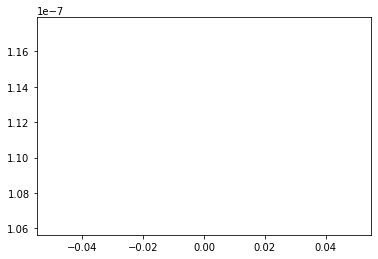

In [92]:
#Example continued
observed_freqs = signal[1] #Add noise later
observed_mean_freq = np.mean(observed_freqs)
normalized_observed_doppler = normalize_dopplers(observed_freqs)
plt.plot(normalized_observed_doppler[1])

def predictor(reciever):
    return normalize_dopplers(get_dopplers(1, emitter, reciever,times))[1]
    
location = get_loc(normalized_observed_doppler, predictor, 1, 180)


In [ ]:
plt.plot(normalized_observed_doppler, label='obs')
plt.plot(location[1], label='pred')
plt.legend()

In [76]:
loc = EarthLocation.from_geodetic(Longitude(0, units.degree), Latitude(0, units.degree))
near = generate_nearby(loc.geodetic, 10, 10)
{loc.geodetic: 'hi'}
loc.geodetic.lon

    

<Longitude 0. deg>

In [ ]:
#Run time improvements
#Day / night cycles
#Compare to data / confirm math is correct

#Intensity estimates (?)
#Corrections for moon radius
#Gravitational(?) correction
#Light second adjustments for different reciever times (time is weird)


#How reflection actually works off of moon
#Error bounding on all steps (i.e. locations on earth, frequency width)
